In [29]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import purify_function,get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,Spectra_Loss_MSE,Spectra_Loss_MAE




# Universal font size
FS = 18

# Theory

Assume that we have GRF perturbed strong lensing event. First, we want to model it without GRF perturbations and consider the residuals.

## Data

simulation: $\psi(\vec{p}_{0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  
model 1: $\psi(\vec{p_0})$  
$res_{0}=Im(\delta \psi(A_{0},\beta_{0},\phi_{0})+\psi(\vec{p}_{0})-\psi(\vec{p_1}))$

,where $\vec{p}$ is a set of source light and unperturbed lens mass parameters and $A_{0},\beta_{0},\phi_{0}$ are correpsondingly amplitude,power slope and phase realisation of GRF power spectrum. Index 0 would refer to true values or zeroth aproximation.

## Model

mock: $\psi(\vec{p}_{0})+\delta \psi(A^{i},\beta^{j},\phi_{0})$  
model 2: $\psi(\vec{p_0})$  
$res^{i,j}=Im(\delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2}))$

,where we assume that we know the exact lens-source parameters \vec{p_0}, and exact GRF phase \phi_{0}

## Loss
$ PS\{ res_{0} \}=|FFT\{res_{0}*mask\_ring\}|^{2} $  
$\mathcal{L}^{ij}=|| \ PS\{res_{0}\} - PS\{res^{i,j}\} \ ||$

## Pipeline

Given lens args $\vec{p}_{0}$ and GRF's phase $\phi_{0}$,

simulate data

logA,beta -> GRF potential -> perturbed image -> residuals with unperturbed image -> power spectrum of residuals


# Lensing setup

In [11]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

## Data grids

In [12]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [13]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [14]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [15]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

kwargs_noise={'background_rms': np.zeros((npix, npix)), 'exposure_time': np.inf}

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,kwargs_noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

perturbed_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

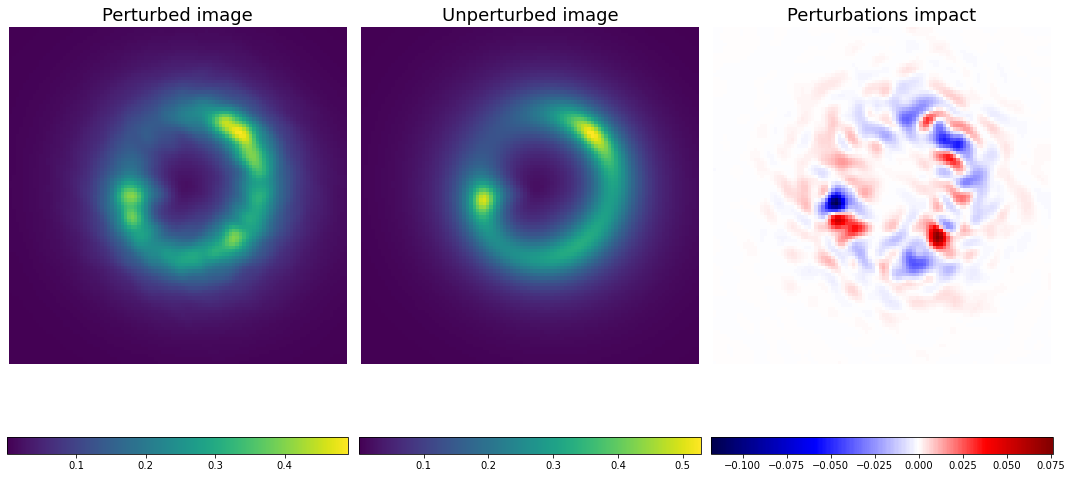

In [16]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(perturbed_image, origin='lower')
ax[0].set_title("Perturbed image", fontsize=FS)


im1=ax[1].imshow(unperturbed_image, origin='lower')
ax[1].set_title("Unperturbed image", fontsize=FS)


resid_true=perturbed_image-unperturbed_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Einstein ring Mask

In [17]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

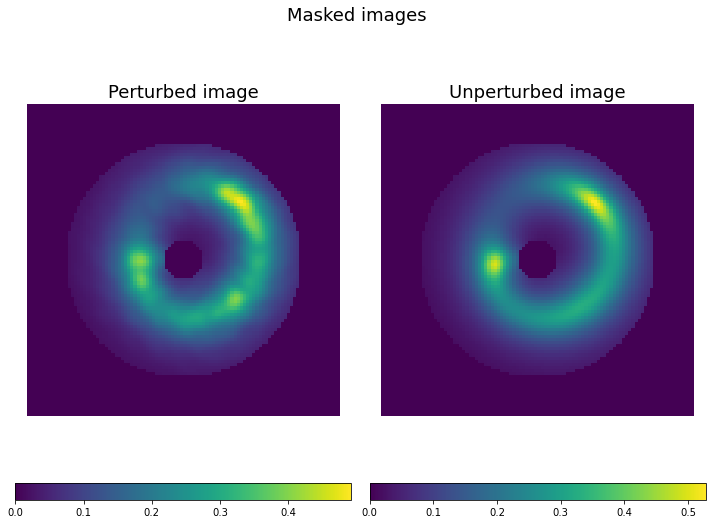

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(perturbed_image*mask, origin='lower')
ax1.set_title("Perturbed image", fontsize=FS)
img2 = ax2.imshow(unperturbed_image*mask, origin='lower')
ax2.set_title("Unperturbed image", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [19]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
@jax.partial(jax.jit,static_argnums=(1,))
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

# Target spectrum, Initial guess

In [20]:
#Compute Target Power spectrum of data residuals 
resid_true=perturbed_image-unperturbed_image
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)

In [21]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,resid_true_spectrum))
GRF_init_guess=np.array(res.x)

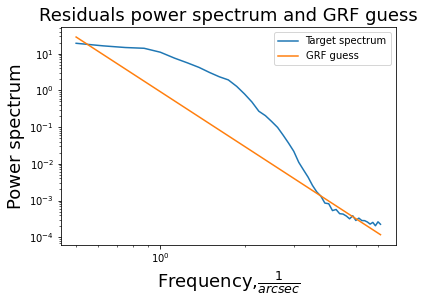

In [22]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,resid_true_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='GRF guess')
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF fitting

## MAE loss function

In [23]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)
GRF_Loss_args=(GRF_seed,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_perfect_case,*GRF_Loss_args)

In [24]:
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

Loss: Guess=207.09, True:0.00
Grad Loss in guess: grad(logA)=0.14, grad(Beta)=-2.91


Text(0.5, 1.0, 'Log(Abs(Hessian))')

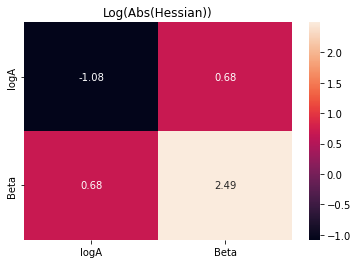

In [25]:
print('Loss: Guess={:.2f}, True:{:.2f}'.format(loss_func(GRF_init_guess),loss_func([GRF_LogAmp,GRF_beta])))
grad_loss=grad_loss_func(GRF_init_guess)
print('Grad Loss in guess: grad(logA)={:.2f}, grad(Beta)={:.2f}'.format(grad_loss[0],grad_loss[1]))

hess_loss=hess_loss_func(GRF_init_guess)
sns.heatmap(np.log10(np.abs(hess_loss)),xticklabels=['logA','Beta'],yticklabels=['logA','Beta'],annot=True,fmt='.2f')
plt.title('Log(Abs(Hessian))')

## Loss function and Grads

In [26]:
'''GRF_Amps_array_narrow=np.linspace(-7.05,-6.95,100)
GRF_Betas_array_narrow=np.linspace(1.5,2.5,100)

GRF_losses_grid_narrow=np.zeros((100,100))
GRF_Amps_grad_grid_narrow=np.zeros((100,100))
GRF_Betas_grad_grid_narrow=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid_narrow[i,j]=loss_func([GRF_Amps_array_narrow[i],GRF_Betas_array_narrow[j]])
    grad=grad_loss_func([GRF_Amps_array_narrow[i],GRF_Betas_array_narrow[j]])
    GRF_Amps_grad_grid_narrow[i,j]=grad[0]
    GRF_Betas_grad_grid_narrow[i,j]=grad[1]'''

100%|█████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


In [30]:
'''np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Amps_array_narrow.npy',GRF_Amps_array_narrow)
np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Betas_array_narrow.npy',GRF_Betas_array_narrow)
np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_losses_grid_narrow.npy',GRF_losses_grid_narrow)
np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Amps_grad_grid_narrow.npy',GRF_Amps_grad_grid_narrow)
np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Betas_grad_grid_narrow.npy',GRF_Betas_grad_grid_narrow)'''

In [31]:
GRF_Amps_array_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Amps_array_narrow.npy',allow_pickle=True)
GRF_Betas_array_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Betas_array_narrow.npy',allow_pickle=True)
GRF_losses_grid_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_losses_grid_narrow.npy',allow_pickle=True)
GRF_Amps_grad_grid_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Amps_grad_grid_narrow.npy',allow_pickle=True)
GRF_Betas_grad_grid_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_Betas_grad_grid_narrow.npy',allow_pickle=True)

In [34]:
GRF_losses_grid_narrow

array([[0.18204704, 0.17409145, 0.16623825, ..., 0.23007903, 0.23159439,
        0.23306996],
       [0.18479574, 0.1768212 , 0.16894935, ..., 0.22841599, 0.22993458,
        0.23141329],
       [0.18755076, 0.1795572 , 0.17166664, ..., 0.22674925, 0.22827107,
        0.22975294],
       ...,
       [0.4808809 , 0.47079046, 0.46082683, ..., 0.11019366, 0.11224005,
        0.11428375],
       [0.48432403, 0.47421077, 0.46422391, ..., 0.1105911 , 0.11258542,
        0.11460958],
       [0.48777454, 0.47763859, 0.4676286 , ..., 0.11110067, 0.11301115,
        0.11499542]])

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21011/2021470410.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


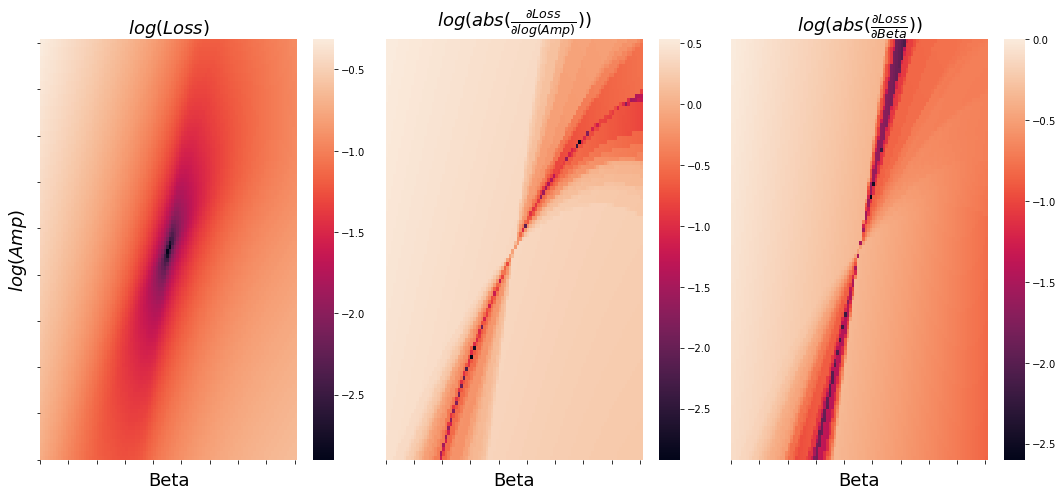

In [33]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array_narrow,9)
x_labels=np.round(GRF_Betas_array_narrow,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid_narrow),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid_narrow)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid_narrow)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

In [ ]:
GRF_Amps_array_narrow=np.linspace(-7.05,-6.95,100)
GRF_Betas_array_narrow=np.linspace(1.5,2.5,100)

GRF_losses_grid_narrow=np.zeros((100,100))
GRF_Amps_grad_grid_narrow=np.zeros((100,100))
GRF_Betas_grad_grid_narrow=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid_narrow[i,j]=loss_func([GRF_Amps_array_narrow[i],GRF_Betas_array_narrow[j]])
    grad=grad_loss_func([GRF_Amps_array_narrow[i],GRF_Betas_array_narrow[j]])
    GRF_Amps_grad_grid_narrow[i,j]=grad[0]
    GRF_Betas_grad_grid_narrow[i,j]=grad[1]

In [204]:
GRF_Amps_array=np.linspace(-10.,-6.,100)
GRF_Betas_array=np.linspace(1.,8.,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:18<00:00,  4.99s/it]


In [320]:
#Adjust history to heatmaps
def reindex_history(history):
  i_min=np.argmin(np.abs(np.nanmin(history[:,0])-GRF_Amps_array))
  j_min=np.argmin(np.abs(np.nanmin(history[:,1])-GRF_Betas_array))

  history_x_labels=j_min+(history[:,1]-np.nanmin(history[:,1]))/(GRF_Betas_array[1]-GRF_Betas_array[0])
  history_y_labels=i_min+(history[:,0]-np.nanmin(history[:,0]))/(GRF_Amps_array[1]-GRF_Amps_array[0])
  return history_x_labels,history_y_labels

In [205]:
history_trust_constr_hess=np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True)

history_hess_x_labels,history_hess_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True))
history_jac_loose_x_labels,history_jac_loose_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_jac_loose_bounds.npy',allow_pickle=True))
history_jac_tight_x_labels,history_jac_tight_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',allow_pickle=True))

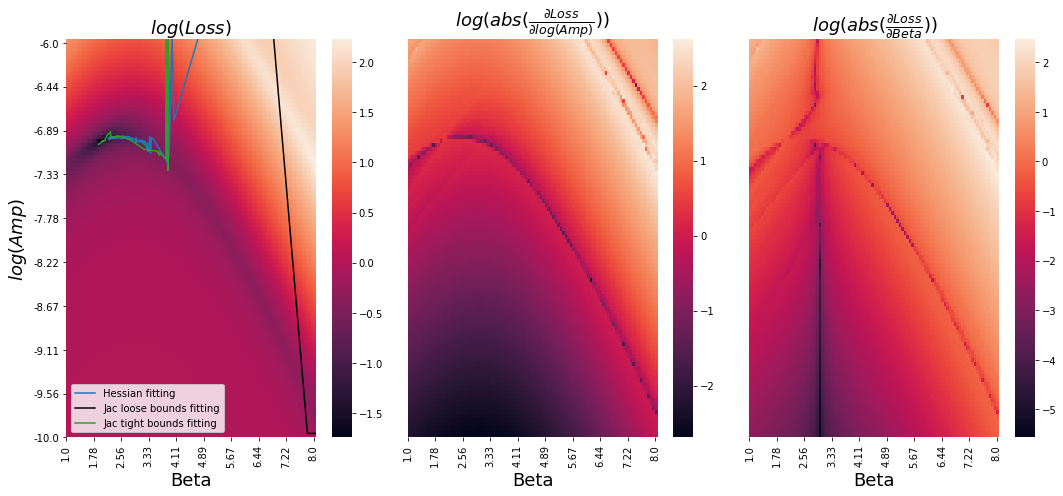

In [212]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)
#Fitting
sns.lineplot(ax=ax[0],x=history_hess_x_labels,y=history_hess_y_labels,label='Hessian fitting',color='C0')
#ax[0].lines[0].set_linestyle((0, (1, 4)))
sns.lineplot(ax=ax[0],x=history_jac_loose_x_labels,y=history_jac_loose_y_labels,label='Jac loose bounds fitting',color='black')
#ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
sns.lineplot(ax=ax[0],x=history_jac_tight_x_labels,y=history_jac_tight_y_labels,label='Jac tight bounds fitting',color='C2')
#ax[0].lines[2].set_linestyle((0, (5, 5)))
ax[0].legend(loc='lower left')

#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

## Optimize

### with hessian

In [74]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([-1.,GRF_beta])
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    207.091483    0.137991 -2.910105
   2   -0.856198    4.945717    206.986700    0.183442 -0.644057
   3   -5.868589    4.822722    34.358590    87.559386  42.138639
   4   -5.943401    4.010312    11.876488    28.462279  10.283309
   5   -6.262875    3.900018    4.869780    12.916308  3.930109
   6   -6.794334    4.062581    1.249628    3.842801  1.479443
   7   -7.160458    3.924507    0.387789    0.636191  0.350079
   8   -7.160458    3.924507    0.387789    0.636191  0.350079
   9   -7.160458    3.924507    0.387789    0.636191  0.350079
  10   -7.160458    3.924507    0.387789    0.636191  0.350079
  11   -7.160458    3.924507    0.387789    0.636191  0.350079
  12   -7.207761    3.898954    0.360317    0.164798  0.175580
  13   -7.207761    3.898954    0.360317    0.164798  0.175580
  14   -7.221226    3.884089    0.357859   -0.349431 -0.001718
  15   -7.221226    3.884089    0.357859   -0.349431 -0.001718
  16   -7.221226    3.884089    0.357859   -

KeyboardInterrupt: ignored

In [195]:
#np.save(Folder+'/Images/history_trust-constr_hess.npy',history)
history_trust_constr_hess=np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True)

In [196]:
history=history_trust_constr_hess

In [197]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

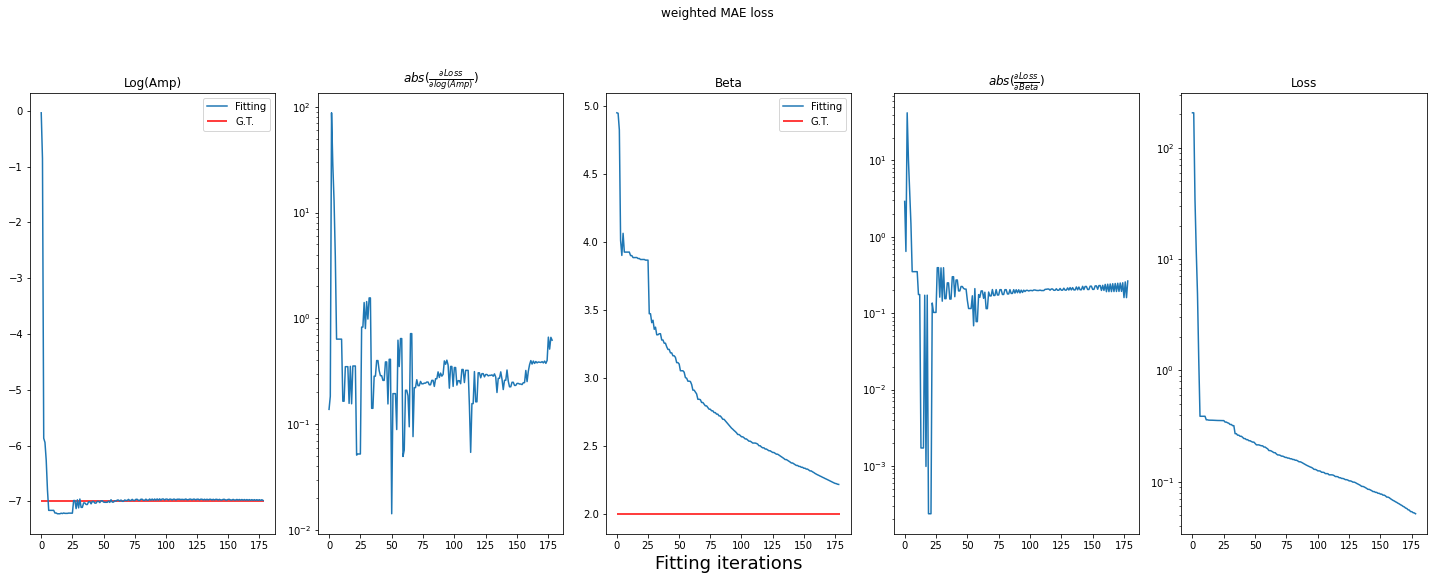

In [199]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### only jac

In [167]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([0.,GRF_beta])
bounds=((-10., -0.), (1., 6.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    207.091483    0.137991 -2.910105
   2   -0.424350    5.356864    207.314332    0.008007  0.407781
   3   -0.431992    5.313520    207.311712    0.003525  0.012143
   4   -0.431992    5.313520    207.311712    0.003525  0.012143
   5   -0.431992    5.313520    207.311712    0.003525  0.012143
   6   -0.436854    5.311473    207.311669    0.003739  0.012419
   7   -0.441763    5.309396    207.311624    0.003970  0.012851
   8   -0.446726    5.307272    207.311575    0.004221  0.013452
   9   -0.451755    5.305082    207.311523    0.004496  0.014247
  10   -0.456862    5.302805    207.311466    0.004799  0.015270
  11   -0.462061    5.300414    207.311402    0.005137  0.016572
  12   -0.467368    5.297880    207.311330    0.005519  0.018223
  13   -0.472807    5.295164    207.311246    0.005959  0.020327
  14   -0.478405    5.292215    207.311148    0.006473  0.023023
  15   -0.484199    5.288968    207.311028    0.007088  0.026501
  16   -0.490237    5.285

In [169]:
#np.save(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',history)

#Bounds ((-10.,0.),(1.,10.))
history_trust_constr_jac_loose_bounds=np.load(Folder+'/Images/history_trust-constr_jac_loose_bounds.npy',allow_pickle=True)

#Bounds ((-10.,0.),(1.,6.))
history_trust_constr_jac_tight_bounds=np.load(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',allow_pickle=True)

In [190]:
history=history_trust_constr_jac_loose_bounds

In [191]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

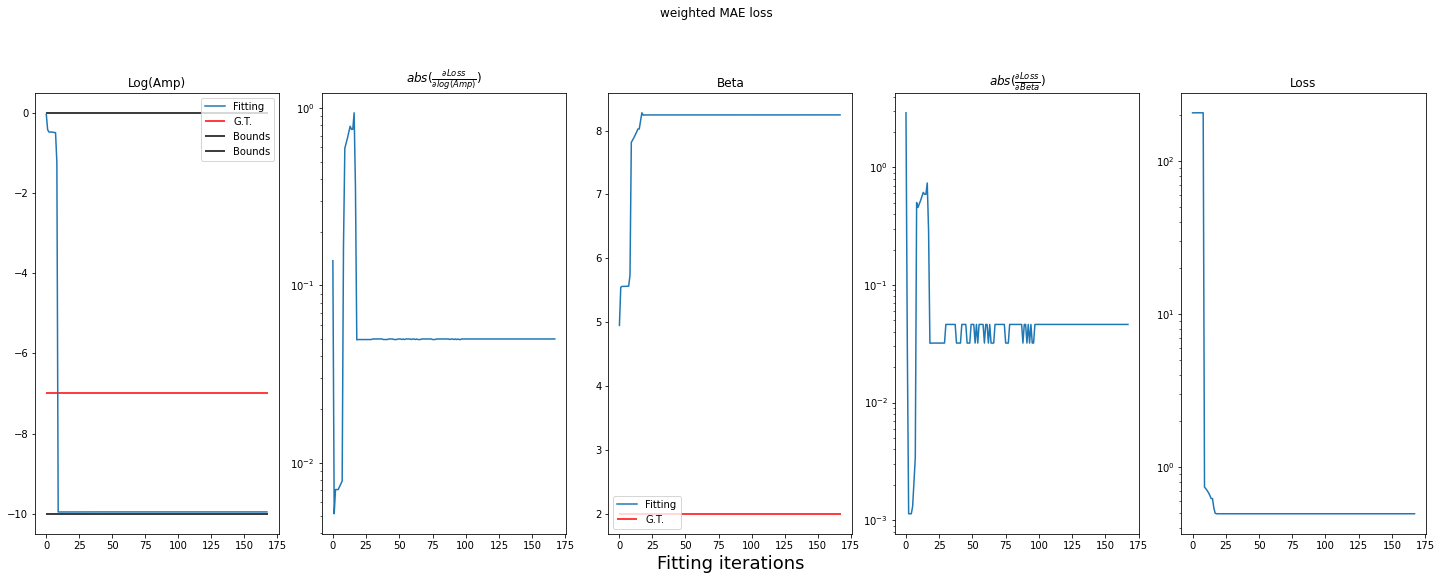

In [194]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

## MSE loss function

In [213]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid_true_spectrum)
GRF_Loss_args=(GRF_seed,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss,*GRF_Loss_args)

In [214]:
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

Loss: Guess=93898.53, True:0.00
Grad Loss in guess: grad(logA)=124.37, grad(Beta)=-2654.02


Text(0.5, 1.0, 'Log(Abs(Hessian))')

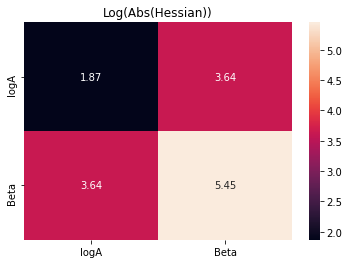

In [215]:
print('Loss: Guess={:.2f}, True:{:.2f}'.format(loss_func(GRF_init_guess),loss_func([GRF_LogAmp,GRF_beta])))
grad_loss=grad_loss_func(GRF_init_guess)
print('Grad Loss in guess: grad(logA)={:.2f}, grad(Beta)={:.2f}'.format(grad_loss[0],grad_loss[1]))

hess_loss=hess_loss_func(GRF_init_guess)
sns.heatmap(np.log10(np.abs(hess_loss)),xticklabels=['logA','Beta'],yticklabels=['logA','Beta'],annot=True,fmt='.2f')
plt.title('Log(Abs(Hessian))')

## Loss function and grads

In [216]:
GRF_Amps_array=np.linspace(-7.05,-6.95,100)
GRF_Betas_array=np.linspace(1.5,2.5,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:24<00:00,  5.05s/it]


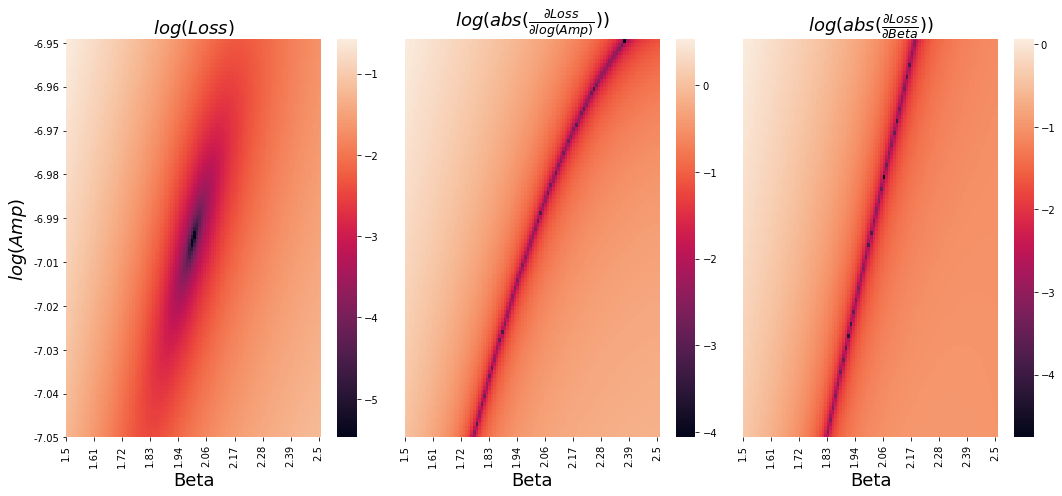

In [217]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

In [235]:
GRF_Amps_array=np.linspace(-10.,-6.,100)
GRF_Betas_array=np.linspace(1.,8.,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:23<00:00,  5.04s/it]


In [236]:
history_hess_x_labels,history_hess_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_hess.npy',allow_pickle=True))
history_jac_loose_x_labels,history_jac_loose_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_jac_loose_bounds.npy',allow_pickle=True))
history_jac_tight_x_labels,history_jac_tight_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',allow_pickle=True))

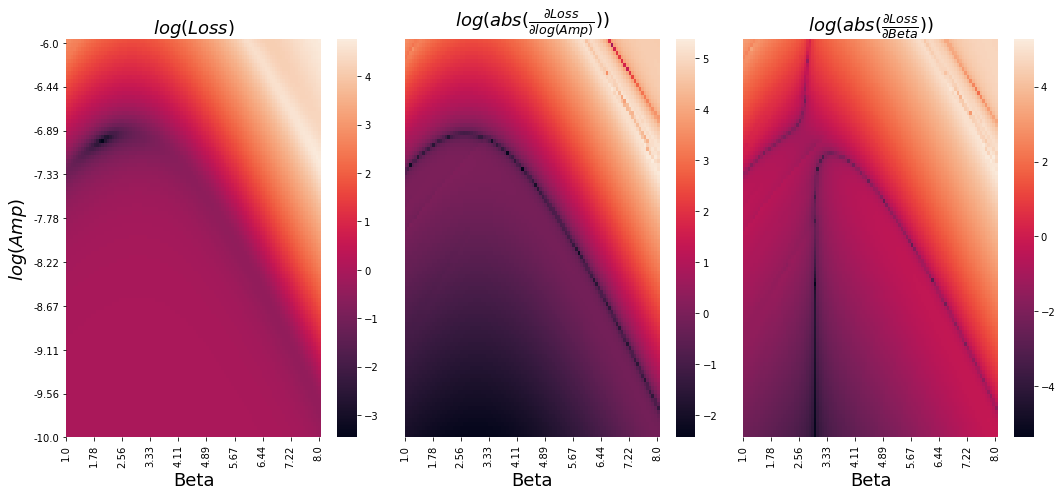

In [286]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)
#Fitting
#sns.lineplot(ax=ax[0],x=history_hess_x_labels,y=history_hess_y_labels,label='Hessian fitting',color='C0')
#ax[0].lines[0].set_linestyle((0, (1, 4)))
#sns.lineplot(ax=ax[0],x=history_jac_loose_x_labels,y=history_jac_loose_y_labels,label='Jac loose bounds fitting',color='black')
#ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
#sns.lineplot(ax=ax[0],x=history_jac_tight_x_labels,y=history_jac_tight_y_labels,label='Jac tight bounds fitting',color='C2')
#ax[0].lines[2].set_linestyle((0, (5, 5)))
#ax[0].legend(loc='lower left')

#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Possible correlation with physical characteristics of the GRF

$A \propto \frac{\sigma^2_{\delta \psi}}{\sum_{k_x} \sum_{k_y} k^{-\beta}} \propto \frac{\sigma^2_{\delta \alpha}}{\sum_{k_x} \sum_{k_y} k^{-\beta+2}} \propto \frac{\sigma^2_{\delta \kappa}}{\sum_{k_x} \sum_{k_y} k^{-\beta+4}}$

In [247]:
k_grid,_=PowerBox_jax.get_k_grid_dx(npix,pix_scl)
k_grid[50,50]=np.inf

In [349]:
variance_stat_sum=np.zeros(100)
deflection_stat_sum=np.zeros(100)
convergence_stat_sum=np.zeros(100)

for i in tqdm(range(100)):
    variance_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]).sum()
    deflection_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]+2).sum()
    convergence_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]+4).sum()

deflection_stat_sum[deflection_stat_sum==np.inf]=np.nan
convergence_stat_sum[convergence_stat_sum==np.inf]=np.nan

Variance_image=np.outer(np.power(10,GRF_Amps_array),variance_stat_sum)
Deflection_image=np.outer(np.power(10,GRF_Amps_array),deflection_stat_sum)
Convergence_image=np.outer(np.power(10,GRF_Amps_array),convergence_stat_sum)

const_Var=np.log10((1e-10*variance_stat_sum[-1])/variance_stat_sum)
const_Def=np.log10((1e-10*deflection_stat_sum[-1])/deflection_stat_sum)
const_Conv=np.log10((1e-10*convergence_stat_sum[-1])/convergence_stat_sum)


const_x_Beta,const_Var_Amp=reindex_history(np.vstack((const_Var,GRF_Betas_array)).T)
const_x_Beta,const_Def_Amp=reindex_history(np.vstack((const_Def,GRF_Betas_array)).T)
const_x_Beta,const_Conv_Amp=reindex_history(np.vstack((const_Conv,GRF_Betas_array)).T)

100%|██████████| 100/100 [00:00<00:00, 506.53it/s]


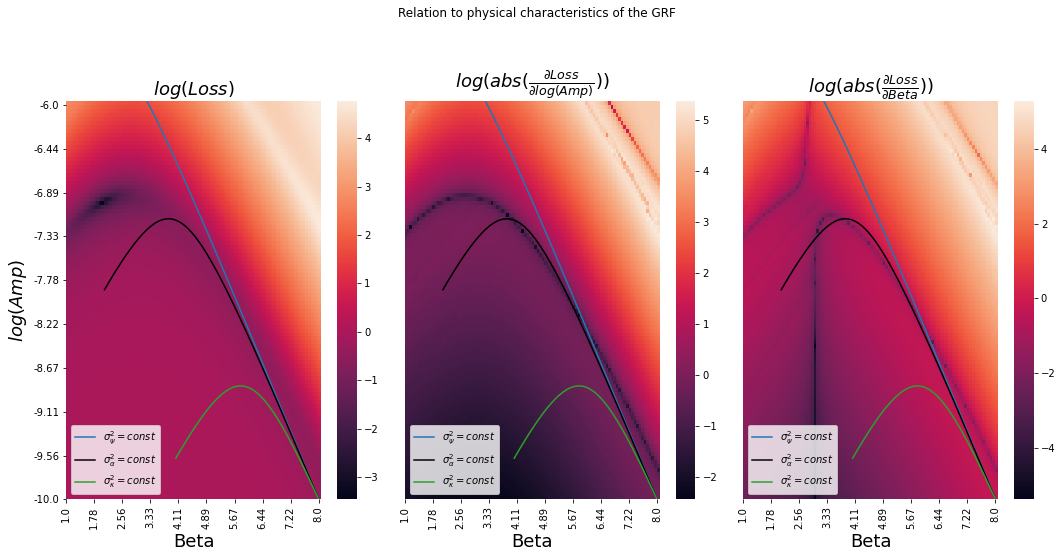

In [354]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)


#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

  #Const levels
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Var_Amp,label=r'$\sigma^2_{\psi}=const$',color='C0')
  ax[i].lines[0].set_linestyle('solid')
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Def_Amp,label=r'$\sigma^2_{\alpha}=const$',color='black')
  ax[i].lines[1].set_linestyle('solid')
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Conv_Amp,label=r'$\sigma^2_{\kappa}=const$',color='C2')
  ax[i].lines[2].set_linestyle('solid')
  ax[i].legend(loc='lower left')
  
 
ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()
fig.suptitle('Relation to physical characteristics of the GRF',y=1.1)

plt.show()

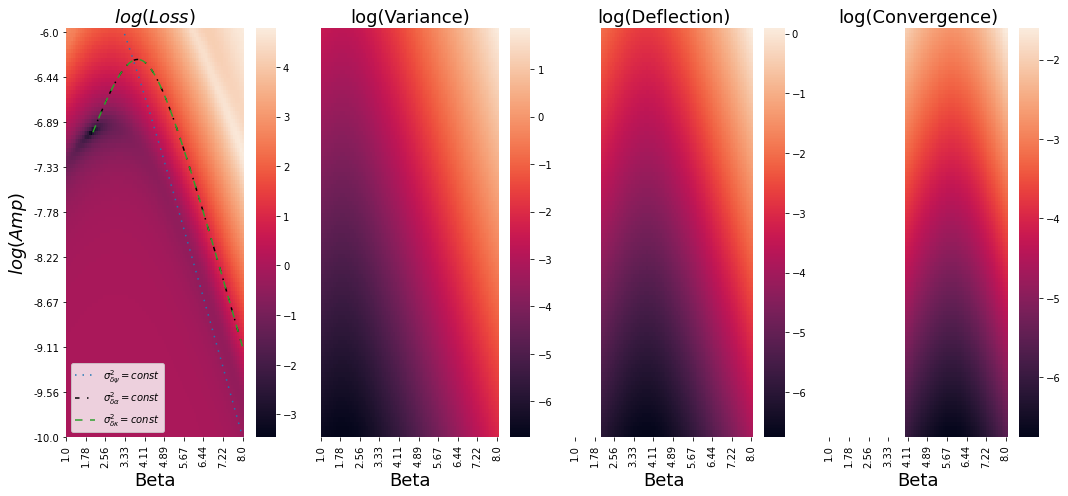

In [337]:
fig,ax=plt.subplots(1,4,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)




#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Const levels
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Var_Amp,label=r'$\sigma^2_{\delta \psi}=const$',color='C0')
ax[0].lines[0].set_linestyle((0, (1, 4)))
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Def_Amp,label=r'$\sigma^2_{\delta \alpha}=const$',color='black')
ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Conv_Amp,label=r'$\sigma^2_{\delta \kappa}=const$',color='C2')
ax[0].lines[2].set_linestyle((0, (5, 5)))
ax[0].legend(loc='lower left')

#Variance
im=sns.heatmap(ax=ax[1],data=np.log10(Variance_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Deflection
im=sns.heatmap(ax=ax[2],data=np.log10(Deflection_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Convergence
im=sns.heatmap(ax=ax[3],data=np.log10(Convergence_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

fig_names=[r'$log(Loss)$','log(Variance)','log(Deflection)','log(Convergence)']
for i in range(4):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

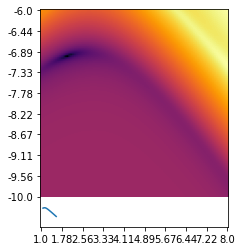

In [309]:
plt.imshow(np.log10(GRF_losses_grid),cmap='inferno')

const_Var_Amp=np.log10((1e-6*variance_stat_sum[15])/variance_stat_sum)
np.vstack((const_Var_Amp,GRF_Betas_array)).T
plt.plot(GRF_Betas_array,const_Var_Amp)


plt.gca().invert_yaxis()
plt.xticks(ticks,labels=xticklabels)
plt.yticks(ticks,labels=yticklabels)
plt.show()

In [313]:
np.vstack((const_Var_Amp,GRF_Betas_array)).T

array([[6.51257407e-07, 1.00000000e+00],
       [6.97806988e-07, 1.07070707e+00],
       [7.44541768e-07, 1.14141414e+00],
       [7.90787854e-07, 1.21212121e+00],
       [8.35769243e-07, 1.28282828e+00],
       [8.78619333e-07, 1.35353535e+00],
       [9.18401304e-07, 1.42424242e+00],
       [9.54138201e-07, 1.49494949e+00],
       [9.84852611e-07, 1.56565657e+00],
       [1.00961452e-06, 1.63636364e+00],
       [1.02759445e-06, 1.70707071e+00],
       [1.03811755e-06, 1.77777778e+00],
       [1.04071312e-06, 1.84848485e+00],
       [1.03515379e-06, 1.91919192e+00],
       [1.02147913e-06, 1.98989899e+00],
       [1.00000000e-06, 2.06060606e+00],
       [9.71282460e-07, 2.13131313e+00],
       [9.36112826e-07, 2.20202020e+00],
       [8.95447798e-07, 2.27272727e+00],
       [8.50355549e-07, 2.34343434e+00],
       [8.01954225e-07, 2.41414141e+00],
       [7.51353928e-07, 2.48484848e+00],
       [6.99606968e-07, 2.55555556e+00],
       [6.47669389e-07, 2.62626263e+00],
       [5.963749

In [307]:
const_Var_Amp=(1e-6*variance_stat_sum[15])/variance_stat_sum

In [308]:
np.log10(const_Var_Amp)

array([ -6.18624732,  -6.15626469,  -6.12811093,  -6.10194001,
        -6.07791362,  -6.05619924,  -6.03696751,  -6.02038872,
        -6.00662876,  -5.99584441,  -5.98817825,  -5.98375347,
        -5.98266897,  -5.98499512,  -5.9907705 ,  -6.        ,
        -6.01265445,  -6.0286718 ,  -6.04795973,  -6.07039945,
        -6.09585042,  -6.12415544,  -6.15514587,  -6.18864663,
        -6.22448062,  -6.26247258,  -6.30245218,  -6.3442563 ,
        -6.38773077,  -6.43273134,  -6.47912426,  -6.52678642,
        -6.5756051 ,  -6.62547764,  -6.67631088,  -6.72802045,
        -6.78053019,  -6.83377135,  -6.88768199,  -6.94220626,
        -6.99729385,  -7.05289936,  -7.10898185,  -7.16550432,
        -7.2224333 ,  -7.27973848,  -7.33739239,  -7.39537005,
        -7.45364874,  -7.51220775,  -7.57102819,  -7.63009277,
        -7.68938566,  -7.74889233,  -7.80859945,  -7.86849473,
        -7.92856685,  -7.98880536,  -8.0492006 ,  -8.10974361,
        -8.17042611,  -8.23124039,  -8.29217929,  -8.35

## Optimize

### with hessian

In [219]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([-1.,GRF_beta])
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   2   -0.856200    4.945830    93802.966953    169.763134 -565.016849
   3   -5.868603    4.823393    2060.714368    10809.194234  5231.891315
   4   -5.963693    4.624140    765.942570    3926.522233  1850.125030
   5   -6.118314    4.552678    295.923386    1480.874943  693.268645
   6   -6.296659    4.512743    109.559732    556.830098  256.625525
   7   -6.493893    4.507251    39.090181    205.817236  94.455083
   8   -6.688996    4.499141    13.265328    74.782952  34.160232
   9   -6.846187    4.427419    4.337609    26.852622  12.029882
  10   -6.993091    4.361358    1.378231    9.337655  4.160843
  11   -7.121073    4.303814    0.494322    3.024544  1.398408
  12   -7.217084    4.258816    0.282365    0.821834  0.455768
  13   -7.268478    4.229778    0.250500    0.127337  0.163385
  14   -7.268478    4.229778    0.250500    0.127337  0.163385
  15   -7.268478    4.229778    0.250500    0.127337  0.16338

In [220]:
np.save(Folder+'/Images/MSEhistory_trust-constr_hess.npy',history)
history_trust_constr_hess=np.load(Folder+'/Images/MSEhistory_trust-constr_hess.npy',allow_pickle=True)

In [221]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

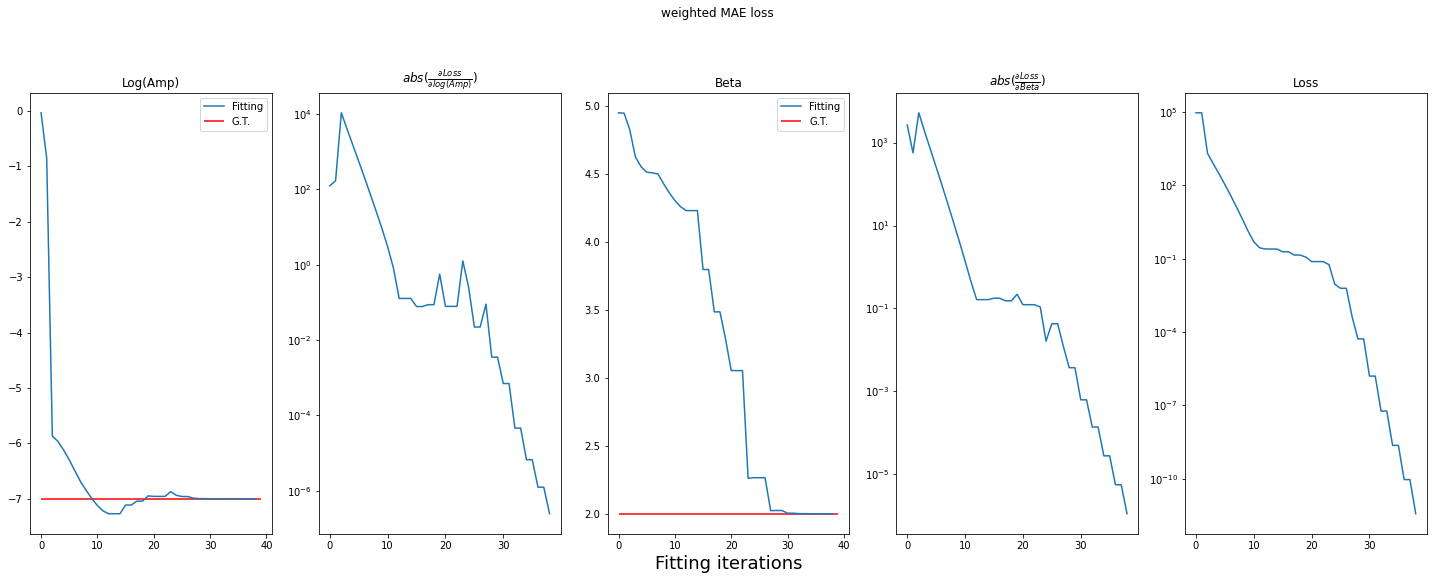

In [222]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### only jacobian

In [228]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([0.,GRF_beta])
bounds=((-10., -0.), (1., 6.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   2   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   3   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   4   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   5   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   6   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   7   -0.034966    4.965073    93898.349367    108.099959  2564.072969
   8   -0.034121    4.950125    93896.132090    120.124269 -2359.932024
   9   -0.044675    4.957270    93886.631516    100.305468  75.198587
  10   -0.095631    4.957070    93881.564259    98.091506  57.651556
  11   -1.323397    4.953307    93670.354084    521.297661  2346.429224
  12   -8.834048    4.924309    0.917340   -0.183921 -0.091864
  13   -8.830379    4.924320    0.916661   -0.185377 -0.092591
  14   -8.826692    4.924331    0.915974   -0.186850 -0.093327
  15   -8.822989    4.92

In [234]:
np.save(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',history)

#Bounds ((-10.,0.),(1.,10.))
#history_trust_constr_jac_loose_bounds=np.load(Folder+'/Images/MSEhistory_trust-constr_jac_loose_bounds.npy',allow_pickle=True)

#Bounds ((-10.,0.),(1.,6.))
#history_trust_constr_jac_tight_bounds=np.load(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',allow_pickle=True)

In [230]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

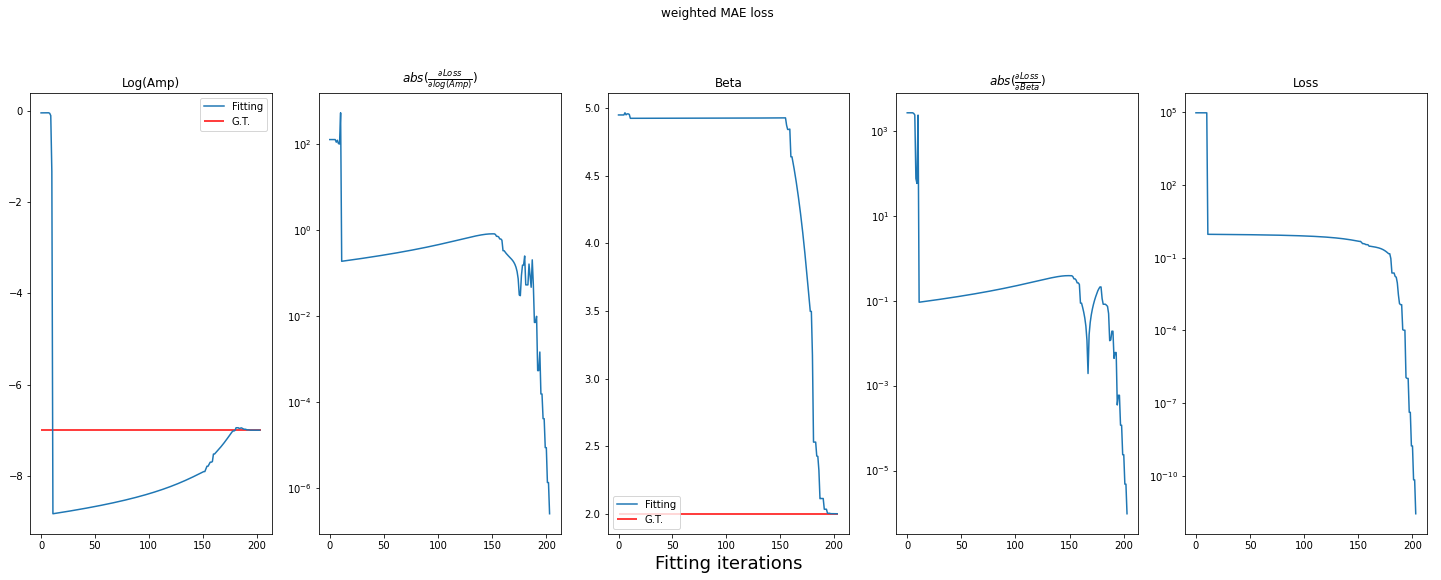

In [232]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()